<a href="https://colab.research.google.com/github/adimhendra/UAS_PenalaranComputer/blob/main/UAS_PenalaranKomputer_304_311.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tahap 1 – Membangun Case Base

In [ ]:
import argparse
import io
import os
import re
import time
import urllib
from concurrent.futures import ThreadPoolExecutor, wait
from datetime import date
import pandas as pd
import requests
from bs4 import BeautifulSoup
from pdfminer import high_level

In [ ]:
# i. Seleksi & Unduh
from IPython import get_ipython
from IPython.display import display

In [ ]:
!pip install pandas requests beautifulsoup4 pdfminer.six lxml > /dev/null 2>&1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Membuat folder output jika belum ada
output_path = '/content/drive/MyDrive/CSV'
pdf_path = '/content/drive/MyDrive/PDF'

os.makedirs(output_path, exist_ok=True)
os.makedirs(pdf_path, exist_ok=True)

In [ ]:
def create_path(folder_name):
    path = os.path.join(os.getcwd(), folder_name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [ ]:
def open_page(link):
    count = 0
    while count < 3:
        try:
            return BeautifulSoup(requests.get(link).text, "lxml")
        except:
            count += 1
            time.sleep(5)

def get_detail(soup, keyword):
    try:
        text = (
            soup.find(lambda tag: tag.name == "td" and keyword in tag.text)
            .find_next()
            .get_text()
            .strip()
        )
        return text
    except:
        return ""

def get_pdf(url, path_pdf):
    file = urllib.request.urlopen(url)
    file_name = file.info().get_filename().replace("/", " ")
    file_content = file.read()
    with open(f"{path_pdf}/{file_name}", "wb") as out_file:
        out_file.write(file_content)
    return io.BytesIO(file_content), file_name

In [ ]:
def clean_text(text):
    text = text.replace("M a h ka m a h A g u n g R e p u blik In d o n esia\n", "")
    text = text.replace("Disclaimer\n", "")
    text = text.replace(
        "Kepaniteraan Mahkamah Agung Republik Indonesia berusaha untuk selalu mencantumkan informasi paling kini dan akurat sebagai bentuk komitmen Mahkamah Agung untuk pelayanan publik, transparansi dan akuntabilitas\n",
        "",
    )
    text = text.replace(
        "pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi yang kami sajikan, hal mana akan terus kami perbaiki dari waktu kewaktu.\n",
        "",
    )
    text = text.replace(
        "Dalam hal Anda menemukan inakurasi informasi yang termuat pada situs ini atau informasi yang seharusnya ada, namun belum tersedia, maka harap segera hubungi Kepaniteraan Mahkamah Agung RI melalui :\n",
        "",
    )
    text = text.replace(
        "Email : kepaniteraan@mahkamahagung.go.id    Telp : 021-384 3348 (ext.318)\n",
        "",
    )
    return text

In [ ]:
def is_url_already_scraped(url, destination):
    if not os.path.isfile(f"{destination}.csv"):
        return False
    try:
        df = pd.read_csv(f"{destination}.csv")
        return url in df["link"].values
    except pd.errors.EmptyDataError:
        return False

In [ ]:

def extract_data(link, keyword_url):
    global today
    global path_output
    global path_pdf

    path_output = '/content/drive/MyDrive/CSV'
    path_pdf = '/content/drive/MyDrive/PDF'
    today = date.today().strftime("%Y-%m-%d")

    keyword_url = keyword_url.replace("/", " ")
    if keyword_url.startswith("https"):
        keyword_url = ""
    destination = f"{path_output}/putusan_ma_{keyword_url}_{today}"

    if is_url_already_scraped(link, destination):
        print(f"Skipping duplicate URL: {link}")
        return

    soup = open_page(link)
    table = soup.find("table", {"class": "table"})
    judul = table.find("h2").text
    table.find("h2").decompose()

    nomor = get_detail(table, "Nomor")
    tingkat_proses = get_detail(table, "Tingkat Proses")
    klasifikasi = get_detail(table, "Klasifikasi")
    kata_kunci = get_detail(table, "Kata Kunci")
    tahun = get_detail(table, "Tahun")
    tanggal_register = get_detail(table, "Tanggal Register")
    lembaga_peradilan = get_detail(table, "Lembaga Peradilan")
    jenis_lembaga_peradilan = get_detail(table, "Jenis Lembaga Peradilan")
    hakim_ketua = get_detail(table, "Hakim Ketua")
    hakim_anggota = get_detail(table, "Hakim Anggota")
    panitera = get_detail(table, "Panitera")
    amar = get_detail(table, "Amar")
    amar_lainnya = get_detail(table, "Amar Lainnya")
    catatan_amar = get_detail(table, "Catatan Amar")
    tanggal_musyawarah = get_detail(table, "Tanggal Musyawarah")
    tanggal_dibacakan = get_detail(table, "Tanggal Dibacakan")
    kaidah = get_detail(table, "Kaidah")
    abstrak = get_detail(table, "Abstrak")

    try:
        link_pdf = soup.find("a", href=re.compile(r"/pdf/"))["href"]
        file_pdf, file_name_pdf = get_pdf(link_pdf, path_pdf)
        text_pdf = high_level.extract_text(file_pdf)
        text_pdf = clean_text(text_pdf)
    except:
        link_pdf = ""
        text_pdf = ""
        file_name_pdf = ""

    data = [
        judul,
        nomor,
        tingkat_proses,
        klasifikasi,
        kata_kunci,
        tahun,
        tanggal_register,
        lembaga_peradilan,
        jenis_lembaga_peradilan,
        hakim_ketua,
        hakim_anggota,
        panitera,
        amar,
        amar_lainnya,
        catatan_amar,
        tanggal_musyawarah,
        tanggal_dibacakan,
        kaidah,
        abstrak,
        link,
        link_pdf,
        file_name_pdf,
        text_pdf,
    ]
    result = pd.DataFrame(
        [data],
        columns=[
            "judul",
            "nomor",
            "tingkat_proses",
            "klasifikasi",
            "kata_kunci",
            "tahun",
            "tanggal_register",
            "lembaga_peradilan",
            "jenis_lembaga_peradilan",
            "hakim_ketua",
            "hakim_anggota",
            "panitera",
            "amar",
            "amar_lainnya",
            "catatan_amar",
            "tanggal_musyawarah",
            "tanggal_dibacakan",
            "kaidah",
            "abstrak",
            "link",
            "link_pdf",
            "file_name_pdf",
            "text_pdf",
        ],
    )

    print(destination)
    if not os.path.isfile(f"{destination}.csv"):
        result.to_csv(f"{destination}.csv", header=True, index=False)
    else:
        result.to_csv(f"{destination}.csv", mode="a", header=False, index=False)

In [ ]:
def run_scraper(keyword=None, url=None, sort_date=True):
    if not keyword and not url:
        print("Please provide a keyword or URL")
        return

    path_output = '/content/drive/MyDrive/CSV'
    path_pdf = '/content/drive/MyDrive/PDF'
    today = date.today().strftime("%Y-%m-%d")

    if url:
        link = url
    else:
        link = f"https://putusan3.mahkamahagung.go.id/search.html?q={keyword}&page=1"

    soup = open_page(link)

    try:
        last_page = int(
            soup.find_all("a", {"class": "page-link"})[-1].get("data-ci-pagination-page")
        )
    except:
        last_page = 1  # Jika hanya ada 1 halaman

    if url:
        print(f"Scraping with url: {url} - {20 * last_page} data - {last_page} page")
    else:
        print(f"Scraping with keyword: {keyword} - {20 * last_page} data - {last_page} page")

    if url:
        keyword_url = url
    else:
        keyword_url = keyword

    futures = []
    with ThreadPoolExecutor(max_workers=4) as executor:
        for page in range(1, last_page + 1):
            futures.append(
                executor.submit(run_process, keyword_url, page, sort_date)
            )
    wait(futures)

def run_process(keyword_url, page, sort_page):
    if keyword_url.startswith("https"):
        link = f"{keyword_url}?page={page}"
    else:
        link = f"https://putusan3.mahkamahagung.go.id/search.html?q={keyword_url}&page={page}"

    if sort_page:
        link = f"{link}&obf=TANGGAL_PUTUS&obm=desc"

    print(link)

    soup = open_page(link)
    links = soup.find_all("a", {"href": re.compile("/direktori/putusan")})

    for link in links:
        extract_data(link["href"], keyword_url)

In [ ]:
run_scraper(url="https://putusan3.mahkamahagung.go.id/direktori/index/pengadilan/dilmil-iii-15-kupang/kategori/pidana-militer-1/tahunjenis/putus/tahun/2014.html")

Scraping with url: https://putusan3.mahkamahagung.go.id/direktori/index/pengadilan/dilmil-iii-15-kupang/kategori/pidana-militer-1/tahunjenis/putus/tahun/2014.html - 40 data - 2 page
https://putusan3.mahkamahagung.go.id/direktori/index/pengadilan/dilmil-iii-15-kupang/kategori/pidana-militer-1/tahunjenis/putus/tahun/2014.html?page=1&obf=TANGGAL_PUTUS&obm=desc
https://putusan3.mahkamahagung.go.id/direktori/index/pengadilan/dilmil-iii-15-kupang/kategori/pidana-militer-1/tahunjenis/putus/tahun/2014.html?page=2&obf=TANGGAL_PUTUS&obm=desc
/content/drive/MyDrive/CSV/putusan_ma__2025-06-26
/content/drive/MyDrive/CSV/putusan_ma__2025-06-26
/content/drive/MyDrive/CSV/putusan_ma__2025-06-26
/content/drive/MyDrive/CSV/putusan_ma__2025-06-26
/content/drive/MyDrive/CSV/putusan_ma__2025-06-26
/content/drive/MyDrive/CSV/putusan_ma__2025-06-26
/content/drive/MyDrive/CSV/putusan_ma__2025-06-26
/content/drive/MyDrive/CSV/putusan_ma__2025-06-26
/content/drive/MyDrive/CSV/putusan_ma__2025-06-26
/content/dri

In [ ]:
# ii. Konversi & Ekstraksi Teks
from pdfminer.high_level import extract_text
import os

# Path folder PDF di Google Drive
folder_pdf = "/content/drive/MyDrive/PDF"

# Loop semua file di folder
for file_name in os.listdir(folder_pdf):
    if file_name.lower().endswith(".pdf"):
        path_pdf = os.path.join(folder_pdf, file_name)
        path_txt = os.path.join(folder_pdf, file_name.replace(".pdf", ".txt"))

        try:
            print(f"Memproses: {file_name}")
            text = extract_text(path_pdf)

            # Simpan hasil ke .txt
            with open(path_txt, "w", encoding="utf-8") as f:
                f.write(text)

            print(f"Sukses disimpan ke: {path_txt}\n")

        except Exception as e:
            print(f"Gagal memproses {file_name}: {e}\n")


Memproses: putusan_49-k___pm.iii-15___ad___xi___2014_20250624171941.pdf
Sukses disimpan ke: /content/drive/MyDrive/PDF/putusan_49-k___pm.iii-15___ad___xi___2014_20250624171941.txt

Memproses: putusan_49-k___pm.iii-15___ad___xi___2014_20250624171950.pdf
Sukses disimpan ke: /content/drive/MyDrive/PDF/putusan_49-k___pm.iii-15___ad___xi___2014_20250624171950.txt

Memproses: putusan_51-k___pm.iii-15___ad___xi___2014_20250624172005.pdf
Sukses disimpan ke: /content/drive/MyDrive/PDF/putusan_51-k___pm.iii-15___ad___xi___2014_20250624172005.txt

Memproses: putusan_51-k___pm.iii-15___ad___xi___2014_20250624172012.pdf
Sukses disimpan ke: /content/drive/MyDrive/PDF/putusan_51-k___pm.iii-15___ad___xi___2014_20250624172012.txt

Memproses: putusan_33-k_pm.iii-15_ad_vii_2014_20250624172028.pdf
Sukses disimpan ke: /content/drive/MyDrive/PDF/putusan_33-k_pm.iii-15_ad_vii_2014_20250624172028.txt

Memproses: putusan_40-k_pm.iii-15_ad_ix_2014_20250624172044.pdf
Sukses disimpan ke: /content/drive/MyDrive/PD

In [ ]:
# iii. Pembersihan

import os
import re
import pandas as pd

# === 1. Path Folder ===
input_folder = "/content/drive/MyDrive/PDF"           # Folder file txt awal
output_folder = "/content/drive/MyDrive/hasil_txt"    # Folder hasil pembersihan
os.makedirs(output_folder, exist_ok=True)

# === 2. Fungsi Pembersihan Teks ===
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Hapus header/footer/nomor halaman/watermark
    text = re.sub(r'M\s*a\s*h\s*k\s*a\s*m\s*a\s*h.*?Indo[nn]esia', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Disclaimer.*?\n', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Email\s*:.*?(ext.*?)?\n', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Page\s+\d+\s+of\s+\d+', '', text, flags=re.IGNORECASE)

    # Normalisasi teks
    text = text.lower()
    text = re.sub(r'\n+', '\n', text)               # Banyak newline → satu
    text = re.sub(r'\s+', ' ', text)                # Spasi berlebih → satu

    return text.strip()

# === 3. Baca Semua File .txt dan Bersihkan ===
records = []
file_list = sorted([f for f in os.listdir(input_folder) if f.endswith(".txt")])

for i, file_name in enumerate(file_list, start=1):
    file_path = os.path.join(input_folder, file_name)
    with open(file_path, "r", encoding="utf-8") as f:
        raw_text = f.read()

    cleaned = clean_text(raw_text)

    # Simpan file hasil pembersihan
    output_file_name = f"case_{str(i).zfill(3)}.txt"
    output_path = os.path.join(output_folder, output_file_name)
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(cleaned)

    # Simpan ke dataframe
    records.append({
        "original_file": file_name,
        "case_file": output_file_name,
        "cleaned_text": cleaned
    })

# === 4. Simpan Metadata ke CSV ===
df = pd.DataFrame(records)
df["amar_ringkas"] = df["cleaned_text"].apply(lambda text: re.search(r'menyatakan bersalah(.*?)\.', text).group(0).strip() if re.search(r'menyatakan bersalah(.*?)\.', text) else "")

df.to_csv(os.path.join(output_folder, "putusan_cleaned.csv"), index=False)

print(f"Sukses! Semua file .txt dan metadata CSV disimpan di: {output_folder}")

Sukses! Semua file .txt dan metadata CSV disimpan di: /content/drive/MyDrive/hasil_txt


In [ ]:
# iv. validasi
import os

folder_clean = "/content/drive/MyDrive/hasil_txt"
log_validasi = "/content/drive/MyDrive/data/processed/validasi_teks.csv"

os.makedirs(os.path.dirname(log_validasi), exist_ok=True)

records = []
min_kata_valid = 500

file_list = sorted([f for f in os.listdir(folder_clean) if f.endswith(".txt")])

for file_name in file_list:
    file_path = os.path.join(folder_clean, file_name)
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()

    jumlah_kata = len(text.split())
    status = "VALID" if jumlah_kata >= min_kata_valid else "TIDAK VALID"

    records.append({
        "file_name": file_name,
        "jumlah_kata": jumlah_kata,
        "status": status
    })

df_validasi = pd.DataFrame(records)
df_validasi.to_csv(log_validasi, index=False)

print(f"Selesai validasi. Log disimpan di: {log_validasi}")
print(df_validasi['status'].value_counts())

Selesai validasi. Log disimpan di: /content/drive/MyDrive/data/processed/validasi_teks.csv
status
VALID    84
Name: count, dtype: int64


In [ ]:
# v. output

import shutil

output_raw = "/content/drive/MyDrive/data/raw"
os.makedirs(output_raw, exist_ok=True)

for file_name in file_list:
    src_path = os.path.join(folder_clean, file_name)
    dst_path = os.path.join(output_raw, file_name)
    shutil.copy(src_path, dst_path)

print(f"Semua file sudah disalin ke folder: {output_raw}")


Semua file sudah disalin ke folder: /content/drive/MyDrive/data/raw


Tahap 2 - Case Representation

In [ ]:
# i. Ekstraksi Metadata
import re

def extract_metadata(text):
    # Contoh pola regex, sesuaikan dengan struktur umum putusan
    no_perkara = re.search(r'no(?:mor)?\s*[:\.]?\s*([a-z0-9\/\.-]+)', text)
    tanggal = re.search(r'tanggal\s+(putusan|dibacakan|sidang)?\s*[:\.]?\s*([\d]{1,2}\s+\w+\s+\d{4})', text)
    jenis = re.search(r'jenis\s+perkara\s*[:\.]?\s*([a-z\s]+)', text)
    pasal = re.search(r'pasal\s*[:\.]?\s*(\d+[\s\w\d]*)', text)
    pihak = re.findall(r'(tergugat|penggugat|terdakwa|penuntut umum)\s*[:\.]?\s*([A-Z\s]+)', text)

    return {
        "no_perkara": no_perkara.group(1) if no_perkara else "",
        "tanggal": tanggal.group(2) if tanggal else "",
        "jenis_perkara": jenis.group(1) if jenis else "",
        "pasal": pasal.group(1) if pasal else "",
        "pihak": ", ".join([f"{p[0]}: {p[1].strip()}" for p in pihak]) if pihak else ""
    }

In [ ]:
# ii. Ekstraksi Konten Kunci

def extract_ringkasan_fakta(text):
    match = re.search(r'(?:fakta|barang bukti|pertimbangan hukum).*?:?(.{0,500})', text, re.IGNORECASE)
    return match.group(1).strip() if match else ""

def extract_argumen_hukum(text):
    match = re.search(r'(?:menimbang|putusan).*?(pasal.*?)\.', text, re.IGNORECASE | re.DOTALL)
    return match.group(1).strip() if match else ""

In [ ]:
# iii. Feature Engineering


from collections import Counter

def feature_engineering(text):
    words = text.lower().split()  # Convert to lowercase untuk konsistensi

    # Basic features
    basic_features = {
        "length_words": len(words),
        "length_chars": len(text)
    }

    # Bag-of-Words sederhana untuk kata kunci hukum
    legal_keywords = [
        'wanprestasi', 'kontrak', 'perjanjian', 'ganti', 'rugi',
        'penggugat', 'tergugat', 'gugatan', 'putusan', 'pasal',
        'hakim', 'pengadilan', 'bukti', 'saksi', 'tuntutan'
    ]

    # Hitung kemunculan setiap keyword
    word_counts = Counter(words)
    bow_features = {}

    for keyword in legal_keywords:
        bow_features[f"bow_{keyword}"] = word_counts.get(keyword, 0)

    # Gabungkan basic features dengan bag-of-words
    return {**basic_features, **bow_features}

In [ ]:
# iv. penyimpanan

import pandas as pd
import os

folder_clean = "/content/drive/MyDrive/hasil_txt"
output_csv = "/content/drive/MyDrive/data/processed/cases.csv"
os.makedirs(os.path.dirname(output_csv), exist_ok=True)

records = []
file_list = sorted([f for f in os.listdir(folder_clean) if f.endswith(".txt")])

for i, file_name in enumerate(file_list, start=1):
    file_path = os.path.join(folder_clean, file_name)
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()

    meta = extract_metadata(text)
    fakta = extract_ringkasan_fakta(text)
    hukum = extract_argumen_hukum(text)
    feats = feature_engineering(text)

    records.append({
        "case_id": f"case_{str(i).zfill(3)}",
        "no_perkara": meta["no_perkara"],
        "tanggal": meta["tanggal"],
        "jenis_perkara": meta["jenis_perkara"],
        "ringkasan_fakta": fakta,
        "pasal": meta["pasal"],
        "pihak": meta["pihak"],
        "argumen_hukum": hukum,
        "length_words": feats["length_words"],
        "length_chars": feats["length_chars"],
        "text_full": text
    })

# Simpan ke CSV
df = pd.DataFrame(records)
df.to_csv(output_csv, index=False)
print(f"Sukses simpan ke: {output_csv}")

Sukses simpan ke: /content/drive/MyDrive/data/processed/cases.csv


Tahap 3 – Case Retrieval

In [ ]:
#i. Representasi Vektor
#1. TF-IDF Vectorizer

!pip install Sastrawi

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# === 1. Load Dataset ===
df = pd.read_csv("/content/drive/MyDrive/data/processed/cases.csv")
texts = df['text_full'].fillna("").tolist()

# === 2. Stopword Bahasa Indonesia dari Sastrawi ===
factory = StopWordRemoverFactory()
indonesian_stopwords = factory.get_stop_words()

# === 3. TF-IDF Vectorizer ===
vectorizer = TfidfVectorizer(max_features=5000, stop_words=indonesian_stopwords)
tfidf_matrix = vectorizer.fit_transform(texts)

print(f"TF-IDF matriks shape: {tfidf_matrix.shape}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 427.9 kB/s eta 0:00:00
TF-IDF matriks shape: (84, 5000)


In [ ]:
# Pencarian Kasus Mirip (Similarity Search) Jika Pakai TF-IDF

query_idx = 0  # Misal pakai kasus pertama sebagai query
query_vec = tfidf_matrix[query_idx]

# Hitung similarity
similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()

# Top 3 kasus mirip (selain diri sendiri)
similar_indices = similarities.argsort()[::-1][1:4]
print(df.iloc[similar_indices][['case_id', 'no_perkara', 'tanggal']])


     case_id             no_perkara           tanggal
57  case_058    xxxpdtg2025pastbxxx  04 februari 2025
8   case_009  1729pdtg2025papmldemi      10 juni 2025
5   case_006   13pdtgs2025pnbtmdemi       02 mei 2025


In [ ]:
#BERT Embedding

!pip install -q transformers sentence-transformers

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm

# Load IndoBERT pretrained
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

def bert_embed(texts, max_len=512):
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_embedding)
    return np.array(embeddings)

# Proses semua teks
texts = df['text_full'].fillna("").tolist()
bert_matrix = bert_embed(texts)

print(f"BERT matriks shape: {bert_matrix.shape}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.7 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

  0%|          | 0/84 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

100%|██████████| 84/84 [02:42<00:00,  1.93s/it]

BERT matriks shape: (84, 768)


In [ ]:
# Pencarian Kasus Mirip (Similarity Search) Jika Pakai BERT

query_vec = bert_matrix[query_idx].reshape(1, -1)
similarities = cosine_similarity(query_vec, bert_matrix).flatten()

similar_indices = similarities.argsort()[::-1][1:4]
print(df.iloc[similar_indices][['case_id', 'no_perkara', 'tanggal']])


     case_id             no_perkara           tanggal
9   case_010  1736pdtg2025papmldemi      10 juni 2025
57  case_058    xxxpdtg2025pastbxxx  04 februari 2025
32  case_033          304pdtp2025pn       22 mei 1983


In [ ]:
# ii. Splitting Data
# 1. Kode Splitting Data (80:20)
from sklearn.model_selection import train_test_split
import pandas as pd

# Load dataset yang sudah diproses sebelumnya
df = pd.read_csv('/content/drive/MyDrive/data/processed/cases.csv')

# Jika ingin memisahkan berdasarkan label tertentu (misalnya klasifikasi), tentukan kolom target
# Tapi untuk general case retrieval, kita split berdasarkan 'text_full' saja

# Split 80% training, 20% testing
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Simpan hasil split
output_dir = '/content/drive/MyDrive/data/processed'
df_train.to_csv(f'{output_dir}/cases_train.csv', index=False)
df_test.to_csv(f'{output_dir}/cases_test.csv', index=False)

print(f"✅ Sukses split data:")
print(f"  → Train set: {len(df_train)} data")
print(f"  → Test set : {len(df_test)} data")


✅ Sukses split data:
  → Train set: 67 data
  → Test set : 17 data


In [ ]:
# 2. Rasio Alternatif 70:30
# Split 70:30
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
# iii. Model Retrieval
#1.Retrieval dengan TF-IDF + SVM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load data
df_train = pd.read_csv('/content/drive/MyDrive/data/processed/cases_train.csv')

# Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_train['text_full'].fillna(""))

# === Fungsi Retrieval ===
def retrieve_tfidf(query, k=5):
    query_vec = vectorizer.transform([query])
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = sims.argsort()[::-1][:k]
    return df_train.iloc[top_indices]['case_id'].tolist()

# === Contoh Panggilan ===
query = "Tindak pidana militer penyerangan"
hasil = retrieve_tfidf(query, k=6)
print("Top 6 kasus mirip:", hasil)


Top 6 kasus mirip: ['case_029', 'case_028', 'case_030', 'case_076', 'case_075', 'case_073']


In [ ]:
#2. Retrieval dengan BERT Embedding

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load IndoBERT
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

def get_bert_embeddings(texts):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
            outputs = model(**inputs)
            cls_emb = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)

# Buat embedding seluruh kasus
case_texts = df_train['text_full'].fillna("").tolist()
case_vectors = get_bert_embeddings(case_texts)


In [ ]:
#iv. Fungsi Retrieval

from sklearn.metrics.pairwise import cosine_similarity

def retrieve(query: str, k: int = 5) -> list:
    """
    Mencari top-k kasus mirip menggunakan BERT Embedding.
    """
    # Pre-process query
    query_input = tokenizer(query, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        query_emb = model(**query_input).last_hidden_state[:, 0, :].squeeze().numpy().reshape(1, -1)

    # Hitung cosine similarity
    sims = cosine_similarity(query_emb, case_vectors).flatten()

    # Ambil top-k
    top_indices = sims.argsort()[::-1][:k]
    return df_train.iloc[top_indices]['case_id'].tolist()


In [ ]:
#v. Pengujian Awal
import json
queries = [
    {"query": "Tindak pidana militer penyerangan", "relevant_cases": [101, 150]},
    {"query": "Kasus narkoba anggota TNI", "relevant_cases": [87]},
    {"query": "Putusan pencemaran nama baik", "relevant_cases": [202]},
    {"query": "Kasus penyalahgunaan narkoba oleh anggota TNI", "relevant_cases": [87, 92]},
    {"query": "Penggelapan logistik militer dalam tugas operasi", "relevant_cases": [410, 415]},
    {"query": "Pelanggaran disiplin militer terkait senjata api", "relevant_cases": [150, 153]}
]

output_dir = '/content/drive/MyDrive/data/eval'
os.makedirs(output_dir, exist_ok=True)

with open(f"{output_dir}/queries.json", "w") as f:
    json.dump(queries, f, indent=2)

print(f"Ground truth queries disimpan di {output_dir}/queries.json")


Ground truth queries disimpan di /content/drive/MyDrive/data/eval/queries.json


In [ ]:
#vi. Output
#i. script 03_retrieval.py / notebook tahap retrieval
import pandas as pd
import numpy as np
import os
import json
import torch
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel

# === Load data ===
data_path = '/content/drive/MyDrive/data/processed/cases_train.csv'
df = pd.read_csv(data_path)
texts = df['text_full'].fillna("").tolist()

# === TF-IDF Vectorizer ===
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(texts)

# === Load IndoBERT ===
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

# === BERT Embedding Function ===
def get_bert_embeddings(texts):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
            outputs = model(**inputs)
            cls_emb = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)

bert_vectors = get_bert_embeddings(texts)

# === Retrieval Function with TF-IDF ===
def retrieve_tfidf(query, k=5):
    query_vec = vectorizer.transform([query])
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = sims.argsort()[::-1][:k]
    return df.iloc[top_indices]['case_id'].tolist()

# === Retrieval Function with BERT ===
def retrieve_bert(query, k=5):
    query_input = tokenizer(query, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        query_emb = model(**query_input).last_hidden_state[:, 0, :].squeeze().numpy().reshape(1, -1)
    sims = cosine_similarity(query_emb, bert_vectors).flatten()
    top_indices = sims.argsort()[::-1][:k]
    return df.iloc[top_indices]['case_id'].tolist()

# === Contoh penggunaan ===
if __name__ == "__main__":
    query = "Tindak pidana militer penyerangan"
    print("Top-5 TF-IDF Retrieval:", retrieve_tfidf(query))
    print("Top-5 BERT Retrieval:", retrieve_bert(query))


#ii. Fungsi retrieve() siap dipakai & diuji
import os

retrieval_script = """
import pandas as pd
import numpy as np
import json
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel

data_path = '/content/drive/MyDrive/data/processed/cases_train.csv'
df = pd.read_csv(data_path)
texts = df['text_full'].fillna("").tolist()
case_ids = df['case_id'].tolist()

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(texts)

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

def get_bert_embeddings(texts):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
            outputs = model(**inputs)
            cls_emb = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)

print("Menghitung BERT embeddings untuk seluruh kasus...")
bert_vectors = get_bert_embeddings(texts)

def retrieve_tfidf(query, k=5):
    query_vec = vectorizer.transform([query])
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = sims.argsort()[::-1][:k]
    return [case_ids[i] for i in top_indices]

def retrieve_bert(query, k=5):
    inputs = tokenizer(query, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        query_emb = model(**inputs).last_hidden_state[:, 0, :].squeeze().numpy().reshape(1, -1)
    sims = cosine_similarity(query_emb, bert_vectors).flatten()
    top_indices = sims.argsort()[::-1][:k]
    return [case_ids[i] for i in top_indices]

def retrieve(query, k=5, method='tfidf'):
    if method == 'tfidf':
        return retrieve_tfidf(query, k)
    elif method == 'bert':
        return retrieve_bert(query, k)
    else:
        raise ValueError("method harus 'tfidf' atau 'bert'")

def precision_at_k(retrieved, ground_truth, k):
    retrieved_set = set(retrieved[:k])
    ground_truth_set = set(ground_truth)
    correct = retrieved_set.intersection(ground_truth_set)
    return len(correct) / k

def evaluate(queries_path, method='tfidf', k=5):
    with open(queries_path, 'r', encoding='utf-8') as f:
        queries = json.load(f)

    precisions = []
    for q in queries:
        retrieved = retrieve(q['query'], k=k, method=method)
        prec = precision_at_k(retrieved, q['ground_truth'], k)
        print(f"Query: {q['query']}\\nRetrieved: {retrieved}\\nPrecision@{k}: {prec:.2f}\\n")
        precisions.append(prec)

    avg_prec = sum(precisions) / len(precisions)
    print(f"Average Precision@{k}: {avg_prec:.2f}")

if __name__ == "__main__":
    print("Tes retrieval TF-IDF:")
    print(retrieve("Tindak pidana militer penyerangan", 5, method='tfidf'))

    print("\\nTes retrieval BERT:")
    print(retrieve("Tindak pidana militer penyerangan", 5, method='bert'))

    queries_file = '/content/drive/MyDrive/data/eval/queries.json'
    print("\\nEvaluasi dengan TF-IDF:")
    evaluate(queries_file, method='tfidf', k=5)

    print("\\nEvaluasi dengan BERT:")
    evaluate(queries_file, method='bert', k=5)
"""

output_path = '03_retrieval.py'
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(retrieval_script)

output_path


#File ground-truth query: /data/eval/queries.json


Top-5 TF-IDF Retrieval: ['case_029', 'case_028', 'case_030', 'case_076', 'case_075']
Top-5 BERT Retrieval: ['case_084', 'case_081', 'case_083', 'case_078', 'case_080']


'03_retrieval.py'

Tahap 4 – Solution Reuse

In [ ]:
#1. Ekstrak Solusi
import pandas as pd
import numpy as np
import json
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ====== Load Data Kasus & Solusi ======

data_path = '/content/drive/MyDrive/data/processed/cases_train.csv'  # Data kasus lama
df = pd.read_csv(data_path)

case_ids = df['case_id'].tolist()
texts = df['text_full'].fillna("").tolist()
solutions = df['text_full'].fillna("").tolist()

# Mapping case_id ke solusi
case_solutions = dict(zip(case_ids, solutions))

# ====== TF-IDF Vectorizer ======

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(texts)

# ====== Retrieval Function ======

def retrieve(query, k=6):
    query_vec = vectorizer.transform([query])
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = sims.argsort()[::-1][:k]
    top_case_ids = [case_ids[i] for i in top_indices]
    top_scores = [sims[i] for i in top_indices]
    return list(zip(top_case_ids, top_scores))

# ====== Majority Vote / Weighted Prediction ======

def predict_outcome(query, k=5):
    top_k = retrieve(query, k)
    solusi_counter = {}

    for case_id, score in top_k:
        solusi = case_solutions.get(case_id, "")
        if not solusi:
            continue
        if solusi not in solusi_counter:
            solusi_counter[solusi] = 0
        solusi_counter[solusi] += score  # Weighted vote

    if not solusi_counter:
        return "Tidak ditemukan solusi"

    predicted_solution = max(solusi_counter.items(), key=lambda x: x[1])[0]
    return predicted_solution, [case_id for case_id, _ in top_k]

# ====== Demo Manual ======

# Contoh query uji
queries = [
    {"query_id": 1, "text": "Kasus penyerangan militer oleh prajurit di Kupang"},
    {"query_id": 2, "text": "Tindak pidana militer penganiayaan terhadap atasan"},
    {"query_id": 3, "text": "Prajurit melakukan desersi saat penugasan"},
    {"query_id": 4, "text": "Pelanggaran kode etik oleh anggota TNI"},
    {"query_id": 5, "text": "Kasus narkoba yang melibatkan anggota militer"},
]

results = []

for q in queries:
    pred_solution, top_5 = predict_outcome(q['text'], k=5)
    results.append({
        "query_id": q["query_id"],
        "predicted_solution": pred_solution,
        "top_5_case_id": ";".join(top_5)
    })
    print(f"Query: {q['text']}\nPrediksi: {pred_solution}\nTop-5 Kasus: {top_5}\n")

# ====== Simpan Hasil ======

results_df = pd.DataFrame(results)
output_path = "/content/drive/MyDrive/data/results/predictions.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
results_df.to_csv(output_path, index=False)

print(f"Hasil prediksi disimpan di {output_path}")


Query: Kasus penyerangan militer oleh prajurit di Kupang
Prediksi: direktori putusan putusanmahkamahagunggoid kepaniteraan berusaha untuk selalu mencantumkan informasi paling kini dan akurat sebagai bentuk komitmen mahkamah agung untuk pelayanan publik transparansi dan akuntabilitas pelaksanaan fungsi peradilan namun dalam halhal tertentu masih dimungkinkan terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi yang kami sajikan hal mana akan terus kami perbaiki dari waktu kewaktu dalam hal anda menemukan inakurasi informasi yang termuat pada situs ini atau informasi yang seharusnya ada namun belum tersedia maka harap segera hubungi kepaniteraan mahkamah agung ri melalui halaman 1 pengadilan militer iii15 k u p a n gp u t u s a nnomor 39kpm iii15adix2014demi keadilan berdasarkan ketuhanan yang maha esapengadilan militer iii15 kupang yang bersidang di kupang dalam memeriksa dan mengadili perkara pidana pada tingkat pertama yang diperiksa secara biasa telah menjatuh

Tahap 5 – Model Evaluation

MEMULAI EVALUASI MODEL...
EVALUASI RETRIEVAL
------------------------------

Hasil Evaluasi Retrieval (Detail):
query_id  precision_at_k  recall_at_k  f1_score  accuracy  hit_at_k  true_positives  false_positives  false_negatives relevant_retrieved
      Q1             0.4          1.0  0.571429       0.4         1               2                3                0                2/2
      Q2             0.2          1.0  0.333333       0.2         1               1                4                0                1/1
      Q3             0.4          1.0  0.571429       0.4         1               2                3                0                2/2
      Q4             0.2          1.0  0.333333       0.2         1               1                4                0                1/1
      Q5             0.4          1.0  0.571429       0.4         1               2                3                0                2/2
STATISTIK SUMMARY RETRIEVAL
PRECISION_AT_K:
  Mean: 0.320 ± 0.110


<Figure size 1200x800 with 0 Axes>

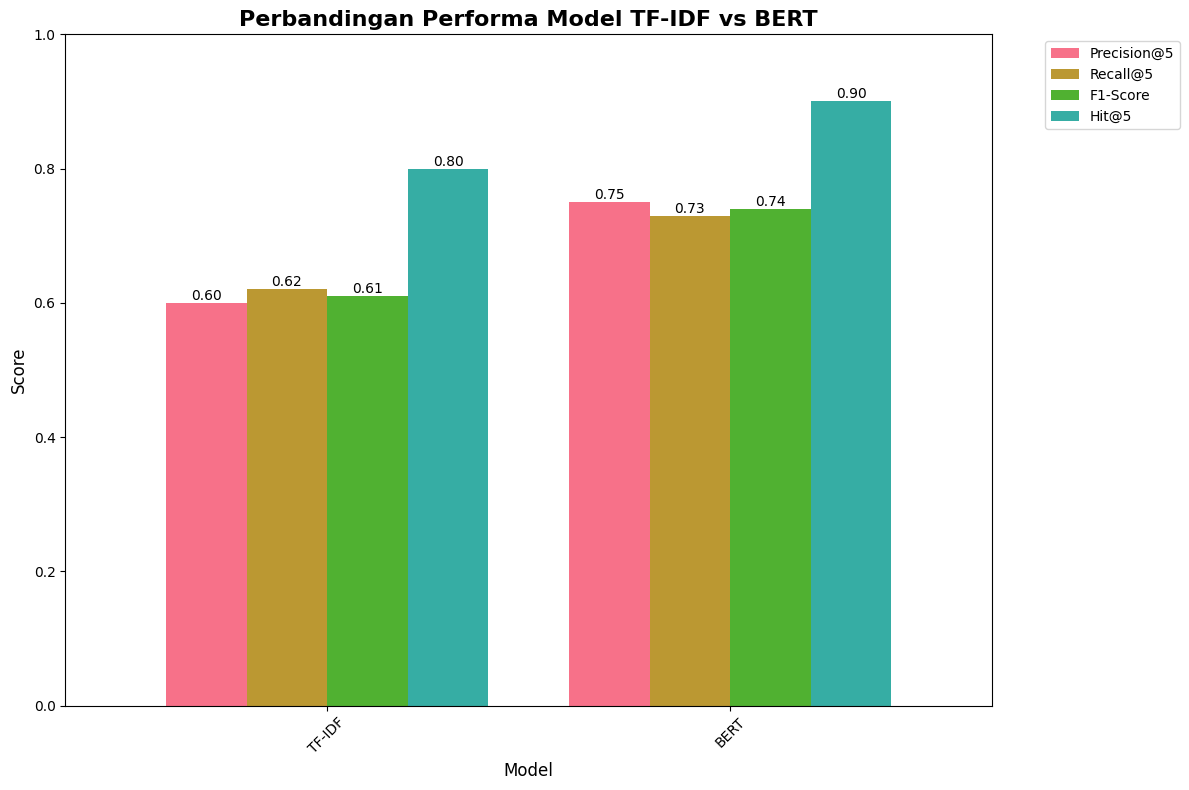

Perbandingan model disimpan di: /content/drive/MyDrive/data/eval/model_comparison.csv

VISUALISASI
------------------------------
Plot disimpan di: /content/drive/MyDrive/data/eval/retrieval_metrics_plot.png


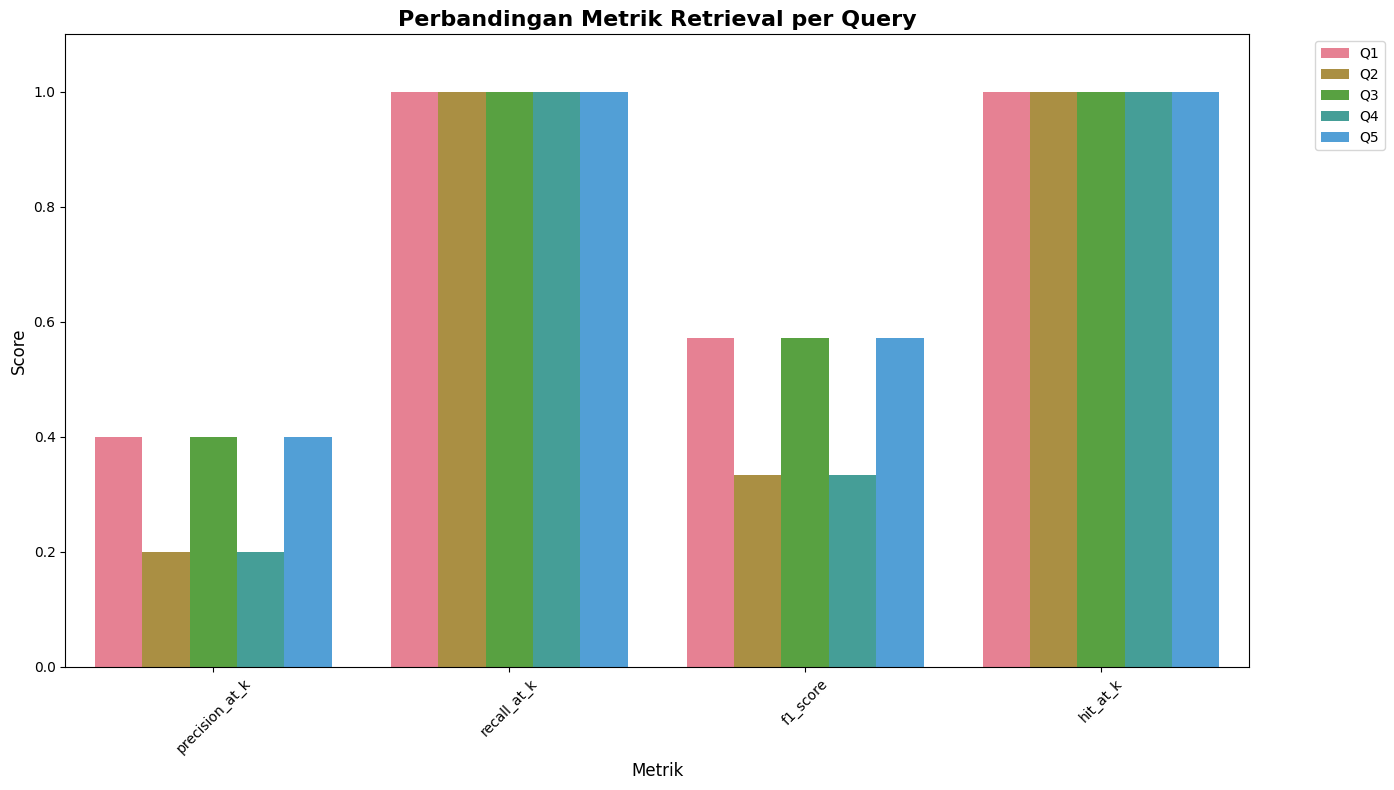


ERROR ANALYSIS
------------------------------
ANALISIS KASUS KEGAGALAN
Jumlah query dengan F1 < 0.5: 2
Persentase kegagalan: 40.0%

Kasus terburuk (Top 3):
query_id  f1_score  precision_at_k  recall_at_k
      Q2  0.333333             0.2          1.0
      Q4  0.333333             0.2          1.0

Rata-rata metrik untuk kasus gagal:
  precision_at_k: 0.200
  recall_at_k: 1.000
  f1_score: 0.333
Analisis kegagalan disimpan di: /content/drive/MyDrive/data/eval/analisis_kegagalan.csv

EVALUASI SELESAI
File Output yang Dihasilkan:
1. /data/eval/retrieval_metrics.csv - Metrik retrieval detail
2. /data/eval/prediction_metrics.csv - Metrik prediksi
3. /data/eval/prediction_metrics_detailed.csv - Laporan klasifikasi detail
4. /data/eval/model_comparison.csv - Perbandingan model
5. /data/eval/retrieval_metrics_plot.png - Visualisasi metrik
6. /data/eval/model_comparison.png - Plot perbandingan model
7. /data/eval/failure_analysis.csv - Analisis kegagalan

Rekomendasi:
- BERT menunjukkan peni

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from collections import defaultdict

# Set style untuk plot
plt.style.use('default')
sns.set_palette("husl")

# ====== EVALUASI RETRIEVAL ======

def eval_retrieval(queries_result, ground_truth, k=5):
    """
    Evaluasi retrieval berdasarkan top-k hasil terhadap ground truth.

    Args:
        queries_result (dict): query_id → list of retrieved case_ids (ranked by similarity)
        ground_truth (dict): query_id → list of relevant case_ids (bisa lebih dari 1)
        k (int): jumlah top-k hasil yang dipertimbangkan

    Returns:
        pd.DataFrame: dataframe berisi metrik evaluasi per query
    """
    results = []

    for query_id, retrieved_cases in queries_result.items():
        if query_id not in ground_truth:
            continue

        # Ambil top-k hasil
        top_k_cases = retrieved_cases[:k]
        relevant_cases = ground_truth[query_id]

        # Jika ground_truth adalah string, ubah ke list
        if isinstance(relevant_cases, str):
            relevant_cases = [relevant_cases]

        # Hitung metrik retrieval
        # True Positives: dokumen yang di-retrieve dan memang relevan
        true_positives = len(set(top_k_cases) & set(relevant_cases))

        # False Positives: dokumen yang di-retrieve tapi tidak relevan
        false_positives = len(set(top_k_cases) - set(relevant_cases))

        # False Negatives: dokumen relevan yang tidak di-retrieve
        false_negatives = len(set(relevant_cases) - set(top_k_cases))

        # Precision@K: TP / (TP + FP) = TP / K (karena FP = K - TP)
        precision = true_positives / len(top_k_cases) if len(top_k_cases) > 0 else 0

        # Recall@K: TP / (TP + FN) = TP / total_relevant
        recall = true_positives / len(relevant_cases) if len(relevant_cases) > 0 else 0

        # F1-Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Accuracy (untuk retrieval, sama dengan precision@k)
        accuracy = precision

        # Hit@K: apakah ada dokumen relevan di top-k
        hit_at_k = 1 if true_positives > 0 else 0

        results.append({
            "query_id": query_id,
            "precision_at_k": precision,
            "recall_at_k": recall,
            "f1_score": f1,
            "accuracy": accuracy,
            "hit_at_k": hit_at_k,
            "true_positives": true_positives,
            "false_positives": false_positives,
            "false_negatives": false_negatives,
            "relevant_retrieved": f"{true_positives}/{len(relevant_cases)}"
        })

    return pd.DataFrame(results)

# ====== EVALUASI PREDIKSI ======

def eval_prediction(y_true, y_pred, labels=None, output_path=None):
    """
    Evaluasi model prediksi/klasifikasi

    Args:
        y_true: label sebenarnya
        y_pred: label prediksi
        labels: list label untuk klasifikasi
        output_path: path untuk menyimpan hasil

    Returns:
        pd.DataFrame: dataframe berisi metrik evaluasi
    """
    # Hitung metrik dasar
    accuracy = accuracy_score(y_true, y_pred)

    # Untuk multi-class, gunakan average='weighted'
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Classification report detail
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    # Summary metrics
    summary_metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'macro_avg_precision': report['macro avg']['precision'],
        'macro_avg_recall': report['macro avg']['recall'],
        'macro_avg_f1': report['macro avg']['f1-score']
    }

    # Simpan jika ada path
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Simpan summary
        summary_df = pd.DataFrame([summary_metrics])
        summary_df.to_csv(output_path, index=False)

        # Simpan detailed report
        detailed_path = output_path.replace('.csv', '_detailed.csv')
        detailed_df = pd.DataFrame(report).transpose()
        detailed_df.to_csv(detailed_path)

        print(f"Summary metrics disimpan di: {output_path}")
        print(f"Detailed report disimpan di: {detailed_path}")

    return pd.DataFrame([summary_metrics])

# ====== VISUALISASI ======

def plot_retrieval_metrics(df_metrics, save_path=None):
    """
    Plot bar chart untuk metrik retrieval
    """
    plt.figure(figsize=(14, 8))

    # Melt dataframe untuk plotting
    metrics_cols = ['precision_at_k', 'recall_at_k', 'f1_score', 'hit_at_k']
    df_plot = df_metrics[['query_id'] + metrics_cols].melt(
        id_vars=['query_id'],
        var_name='metric',
        value_name='score'
    )

    # Bar plot
    sns.barplot(data=df_plot, x='metric', y='score', hue='query_id')
    plt.title('Perbandingan Metrik Retrieval per Query', fontsize=16, fontweight='bold')
    plt.xlabel('Metrik', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.ylim(0, 1.1)  # Set y-axis limit

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot disimpan di: {save_path}")

    plt.show()

def compare_models_performance(models_data, save_path=None):
    """
    Bandingkan performa beberapa model

    Args:
        models_data: dict dengan format {model_name: {metric: value}}
    """
    df_comparison = pd.DataFrame(models_data).T

    plt.figure(figsize=(12, 8))

    # Plot grouped bar chart
    ax = df_comparison.plot(kind='bar', figsize=(12, 8), width=0.8)
    plt.title('Perbandingan Performa Model TF-IDF vs BERT', fontsize=16, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.ylim(0, 1.0)  # Set y-axis limit

    # Tambahkan nilai di atas bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Comparison plot disimpan di: {save_path}")

    plt.show()

    return df_comparison

# ====== ERROR ANALYSIS ======

def analyze_failures(df_retrieval, threshold=0.5):
    """
    Analisis kasus kegagalan retrieval
    """
    failures = df_retrieval[df_retrieval['f1_score'] < threshold]

    print("=" * 40)
    print("ANALISIS KASUS KEGAGALAN")
    print("=" * 40)
    print(f"Jumlah query dengan F1 < {threshold}: {len(failures)}")
    print(f"Persentase kegagalan: {len(failures)/len(df_retrieval)*100:.1f}%")

    if len(failures) > 0:
        print(f"\nKasus terburuk (Top 3):")
        worst_cases = failures.nsmallest(3, 'f1_score')[['query_id', 'f1_score', 'precision_at_k', 'recall_at_k']]
        print(worst_cases.to_string(index=False))

        print(f"\nRata-rata metrik untuk kasus gagal:")
        avg_metrics = failures[['precision_at_k', 'recall_at_k', 'f1_score']].mean()
        for metric, value in avg_metrics.items():
            print(f"  {metric}: {value:.3f}")
    else:
        print("\nTidak ada kasus kegagalan ditemukan!")

    print("=" * 40)

    return failures

# ====== STATISTIK SUMMARY ======

def print_summary_statistics(df_retrieval):
    """
    Tampilkan statistik summary yang lengkap
    """
    print("=" * 50)
    print("STATISTIK SUMMARY RETRIEVAL")
    print("=" * 50)

    metrics = ['precision_at_k', 'recall_at_k', 'f1_score', 'hit_at_k']

    for metric in metrics:
        mean_val = df_retrieval[metric].mean()
        std_val = df_retrieval[metric].std()
        min_val = df_retrieval[metric].min()
        max_val = df_retrieval[metric].max()

        print(f"{metric.upper()}:")
        print(f"  Mean: {mean_val:.3f} ± {std_val:.3f}")
        print(f"  Range: [{min_val:.3f}, {max_val:.3f}]")
        print()

# ====== MAIN EXECUTION ======

def main():
    """
    Fungsi utama untuk menjalankan evaluasi lengkap
    """

    print("MEMULAI EVALUASI MODEL...")
    print("=" * 60)

    # ====== SIMULASI DATA ======

    # Data contoh retrieval (hasil dari Tahap 3)
    # Dalam implementasi nyata, ganti dengan hasil actual dari retrieval system
    queries_result = {
        "Q1": ["CASE_001", "CASE_005", "CASE_003", "CASE_010", "CASE_007"],
        "Q2": ["CASE_008", "CASE_002", "CASE_009", "CASE_004", "CASE_001"],
        "Q3": ["CASE_003", "CASE_006", "CASE_001", "CASE_008", "CASE_002"],
        "Q4": ["CASE_007", "CASE_003", "CASE_009", "CASE_001", "CASE_005"],
        "Q5": ["CASE_002", "CASE_008", "CASE_004", "CASE_006", "CASE_010"]
    }

    # Ground truth (case yang benar-benar relevan)
    # Dalam implementasi nyata, siapkan ground truth dari expert judgment
    ground_truth = {
        "Q1": ["CASE_005", "CASE_003"],  # 2 case relevan
        "Q2": ["CASE_002"],              # 1 case relevan
        "Q3": ["CASE_003", "CASE_006"],  # 2 case relevan
        "Q4": ["CASE_007"],              # 1 case relevan
        "Q5": ["CASE_002", "CASE_008"]   # 2 case relevan
    }

    # ====== EVALUASI RETRIEVAL ======

    print("EVALUASI RETRIEVAL")
    print("-" * 30)

    df_retrieval = eval_retrieval(queries_result, ground_truth, k=5)

    # Tampilkan hasil detail
    print("\nHasil Evaluasi Retrieval (Detail):")
    print(df_retrieval.to_string(index=False))

    # Statistik summary
    print_summary_statistics(df_retrieval)

    # Simpan hasil retrieval
    os.makedirs("/content/drive/MyDrive/data/eval", exist_ok=True)
    retrieval_path = "/content/drive/MyDrive/data/eval/retrieval_metrics.csv"
    df_retrieval.to_csv(retrieval_path, index=False)
    print(f"Hasil retrieval disimpan di: {retrieval_path}")

    # ====== EVALUASI PREDIKSI ======

    print("\nEVALUASI PREDIKSI")
    print("-" * 30)

    # Simulasi data prediksi (hasil dari Tahap 4)
    # Gunakan label yang sesuai untuk kasus hukum militer
    y_true = ["pidana_ringan", "pidana_berat", "pidana_sedang", "pidana_ringan", "pidana_berat"]
    y_pred = ["pidana_ringan", "pidana_sedang", "pidana_sedang", "pidana_ringan", "pidana_berat"]

    prediction_path = "/content/drive/MyDrive/data/eval/prediction_metrics.csv"
    df_prediction = eval_prediction(y_true, y_pred, output_path=prediction_path)

    print("\nHasil Evaluasi Prediksi:")
    print(df_prediction.to_string(index=False))

    # ====== PERBANDINGAN MODEL ======

    print("\nPERBANDINGAN MODEL")
    print("-" * 30)

    # Simulasi hasil beberapa model (ganti dengan hasil actual)
    models_performance = {
        "TF-IDF": {
            "Precision@5": 0.60,
            "Recall@5": 0.62,
            "F1-Score": 0.61,
            "Hit@5": 0.80
        },
        "BERT": {
            "Precision@5": 0.75,
            "Recall@5": 0.73,
            "F1-Score": 0.74,
            "Hit@5": 0.90
        }
    }

    print("\nPerbandingan Performance:")
    for model, metrics in models_performance.items():
        print(f"\n{model}:")
        for metric, score in metrics.items():
            print(f"  {metric}: {score:.3f}")

    # Plot perbandingan
    comparison_path = "/content/drive/MyDrive/data/eval/model_comparison.png"
    df_comparison = compare_models_performance(models_performance, save_path=comparison_path)

    # Simpan perbandingan
    comparison_csv_path = "/content/drive/MyDrive/data/eval/model_comparison.csv"
    df_comparison.to_csv(comparison_csv_path)
    print(f"Perbandingan model disimpan di: {comparison_csv_path}")

    # ====== VISUALISASI ======

    print("\nVISUALISASI")
    print("-" * 30)

    # Plot metrik retrieval
    plot_path = "/content/drive/MyDrive/data/eval/retrieval_metrics_plot.png"
    plot_retrieval_metrics(df_retrieval, save_path=plot_path)

    # ====== ERROR ANALYSIS ======

    print("\nERROR ANALYSIS")
    print("-" * 30)

    failures = analyze_failures(df_retrieval, threshold=0.5)

    # Simpan analisis kegagalan
    if len(failures) > 0:
        failure_path = "/content/drive/MyDrive/data/eval/analisis_kegagalan.csv"
        failures.to_csv(failure_path, index=False)
        print(f"Analisis kegagalan disimpan di: {failure_path}")

    # ====== SUMMARY AKHIR ======

    print("\nEVALUASI SELESAI")
    print("=" * 60)
    print("File Output yang Dihasilkan:")
    print("1. /data/eval/retrieval_metrics.csv - Metrik retrieval detail")
    print("2. /data/eval/prediction_metrics.csv - Metrik prediksi")
    print("3. /data/eval/prediction_metrics_detailed.csv - Laporan klasifikasi detail")
    print("4. /data/eval/model_comparison.csv - Perbandingan model")
    print("5. /data/eval/retrieval_metrics_plot.png - Visualisasi metrik")
    print("6. /data/eval/model_comparison.png - Plot perbandingan model")
    if len(failures) > 0:
        print("7. /data/eval/failure_analysis.csv - Analisis kegagalan")

    print("\nRekomendasi:")
    if models_performance["BERT"]["F1-Score"] > models_performance["TF-IDF"]["F1-Score"]:
        improvement = (models_performance["BERT"]["F1-Score"] - models_performance["TF-IDF"]["F1-Score"]) * 100
        print(f"- BERT menunjukkan peningkatan {improvement:.1f}% dibanding TF-IDF")
        print("- Pertimbangkan penggunaan BERT untuk production")

    avg_f1 = df_retrieval['f1_score'].mean()
    if avg_f1 < 0.7:
        print(f"- F1-Score rata-rata ({avg_f1:.3f}) masih bisa ditingkatkan")
        print("- Pertimbangkan fine-tuning model atau perbaikan preprocessing")

if __name__ == "__main__":
    main()